##  Forecasting using hourly link Utilisation Data

- Name: Kaushik Srivasan
- Branch: 4th year, School of Computing & Data Science, Sai University

For Applied Data Analytics Course, CMI

In [1]:
#Importing all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import statsmodels.api as sm
import plotly.figure_factory as ff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
# Loading the data
data = pd.read_csv('linkstats.csv', parse_dates=['timestamp'])
data


C:\Users\Kaushik Srivatsan\AppData\Local\Temp\ipykernel_30464\4086290553.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('linkstats.csv', parse_dates=['timestamp'])


,timestamp,ifHCInOctets,ifHCOutOctets,ifInErrors,ifOutErrors,ifInUcastPackets,ifOutUcastPackets
0,1703858100,3380.495680,2876.390069,0.0,0.0,4.547973,4.646825
1,1703858400,3408.845196,3060.870004,0.0,0.0,4.684506,4.881705
2,1703858700,3378.864965,2789.810337,0.0,0.0,4.659316,4.735553
3,1703859000,3369.610477,3007.387779,0.0,0.0,4.510157,4.723786
4,1703859300,3411.716231,2774.699436,0.0,0.0,4.493931,4.608065
...,...,...,...,...,...,...,...
21699,1710371400,3260.790124,2613.632927,0.0,0.0,4.314605,4.402983
21700,1710371700,3226.314583,2593.569460,0.0,0.0,4.180355,4.289182
21701,1710372000,3209.951952,2656.685632,0.0,0.0,4.641993,4.633056
21702,1710372300,3301.428362,2660.691485,0.0,0.0,4.338368,4.431473


First we perform general EDA on the data then proceed to attempt forecasting on link utilisation using 3 different methods - Time series regression, ARIMA and then exponential smoothing plotting the forecasted values in plots.

### EDA and Preprocessing of Link utilisation Data

Performing EDA ond data and preprocessing steps - that is checking for stationarity, converting it into hourly utilisation, seasonal decomposition etc.

In [3]:
#Looking at the data organization
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21704 entries, 0 to 21703
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          21704 non-null  object 
 1   ifHCInOctets       21704 non-null  float64
 2   ifHCOutOctets      21704 non-null  float64
 3   ifInErrors         21704 non-null  float64
 4   ifOutErrors        21704 non-null  float64
 5   ifInUcastPackets   21704 non-null  float64
 6   ifOutUcastPackets  21704 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.2+ MB


In [4]:
# Checking statistical information about data
data.describe()

,ifHCInOctets,ifHCOutOctets,ifInErrors,ifOutErrors,ifInUcastPackets,ifOutUcastPackets
count,21704.000000,21704.000000,21704.0,21704.0,21704.000000,21704.000000
mean,3662.194603,3121.831474,0.0,0.0,5.849191,5.989371
std,2106.497138,2165.381802,0.0,0.0,7.300456,7.306464
min,3065.859687,1777.563807,0.0,0.0,4.029608,3.105736
25%,3186.130385,2581.760481,0.0,0.0,4.281504,4.410868
50%,3233.332602,2640.237080,0.0,0.0,4.401067,4.535204
75%,3313.122753,2750.465240,0.0,0.0,4.574064,4.708227
max,39759.369003,51812.894384,0.0,0.0,131.925956,131.954822


In [5]:
#Checking null values
data.isnull().sum()

timestamp            0
ifHCInOctets         0
ifHCOutOctets        0
ifInErrors           0
ifOutErrors          0
ifInUcastPackets     0
ifOutUcastPackets    0
dtype: int64

In [6]:
# Since the problem statement requires us to perform forecasting based on hourly utilization, we need to resample the data from unix timestamps to hourly frequency.

# Convert the timestamp to a datetime object
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')

# Set the timestamp as the index
data.set_index('timestamp', inplace=True)

# Resample the data to hourly frequency, New dataset is data_hourly
data_hourly = data.resample('H').mean()


C:\Users\Kaushik Srivatsan\AppData\Local\Temp\ipykernel_30464\2850441168.py:4: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
C:\Users\Kaushik Srivatsan\AppData\Local\Temp\ipykernel_30464\2850441168.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_hourly = data.resample('H').mean()


In [7]:
data.head()

,ifHCInOctets,ifHCOutOctets,ifInErrors,ifOutErrors,ifInUcastPackets,ifOutUcastPackets
timestamp,,,,,,
2023-12-29 13:55:00,3380.495680,2876.390069,0.0,0.0,4.547973,4.646825
2023-12-29 14:00:00,3408.845196,3060.870004,0.0,0.0,4.684506,4.881705
2023-12-29 14:05:00,3378.864965,2789.810337,0.0,0.0,4.659316,4.735553
2023-12-29 14:10:00,3369.610477,3007.387779,0.0,0.0,4.510157,4.723786
2023-12-29 14:15:00,3411.716231,2774.699436,0.0,0.0,4.493931,4.608065


In [8]:
data_hourly

,ifHCInOctets,ifHCOutOctets,ifInErrors,ifOutErrors,ifInUcastPackets,ifOutUcastPackets
timestamp,,,,,,
2023-12-29 13:00:00,3380.495680,2876.390069,0.0,0.0,4.547973,4.646825
2023-12-29 14:00:00,3460.771250,2888.468703,0.0,0.0,4.908369,5.022037
2023-12-29 15:00:00,3639.167499,3123.803514,0.0,0.0,5.738568,5.842887
2023-12-29 16:00:00,3242.343576,2609.232656,0.0,0.0,4.347367,4.409261
2023-12-29 17:00:00,3245.300846,2610.064319,0.0,0.0,4.376476,4.436609
...,...,...,...,...,...,...
2024-03-13 19:00:00,3275.177637,2663.503587,0.0,0.0,4.433179,4.533775
2024-03-13 20:00:00,4816.574127,4364.801833,0.0,0.0,6.509044,5.907522
2024-03-13 21:00:00,3598.111340,4139.317072,0.0,0.0,5.205367,5.702200


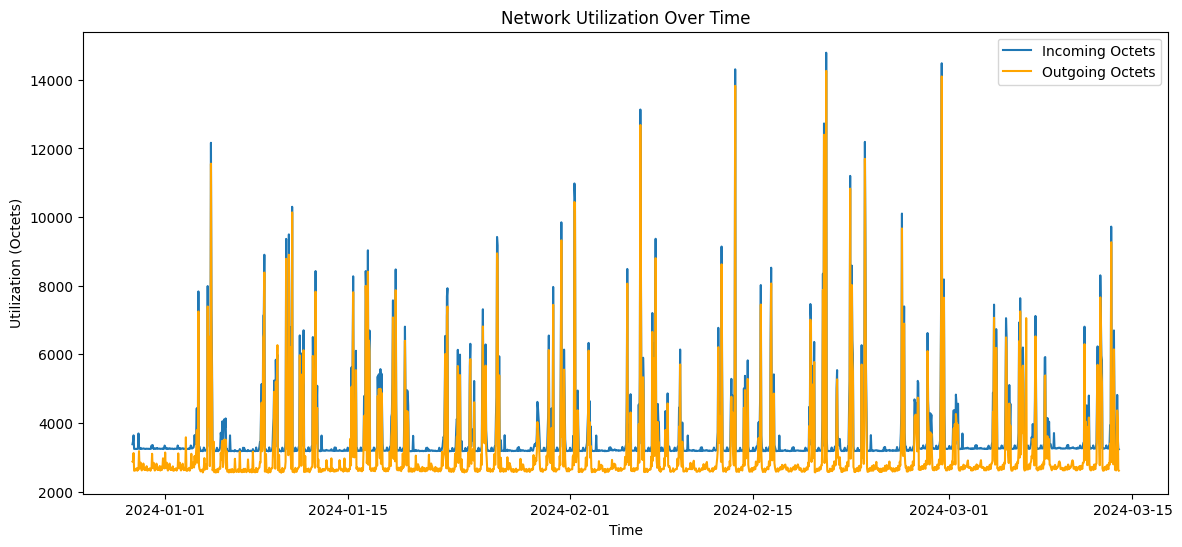

In [9]:
# EDA - Ploting Incoming and Outgoing Octets (ifHCInOctets and ifHCOutOctets) over time.
plt.figure(figsize=(14, 6))
plt.plot(data_hourly['ifHCInOctets'], label='Incoming Octets')
plt.plot(data_hourly['ifHCOutOctets'], label='Outgoing Octets', color='orange')
plt.title('Network Utilization Over Time')
plt.xlabel('Time')
plt.ylabel('Utilization (Octets)')
plt.legend()
plt.show()

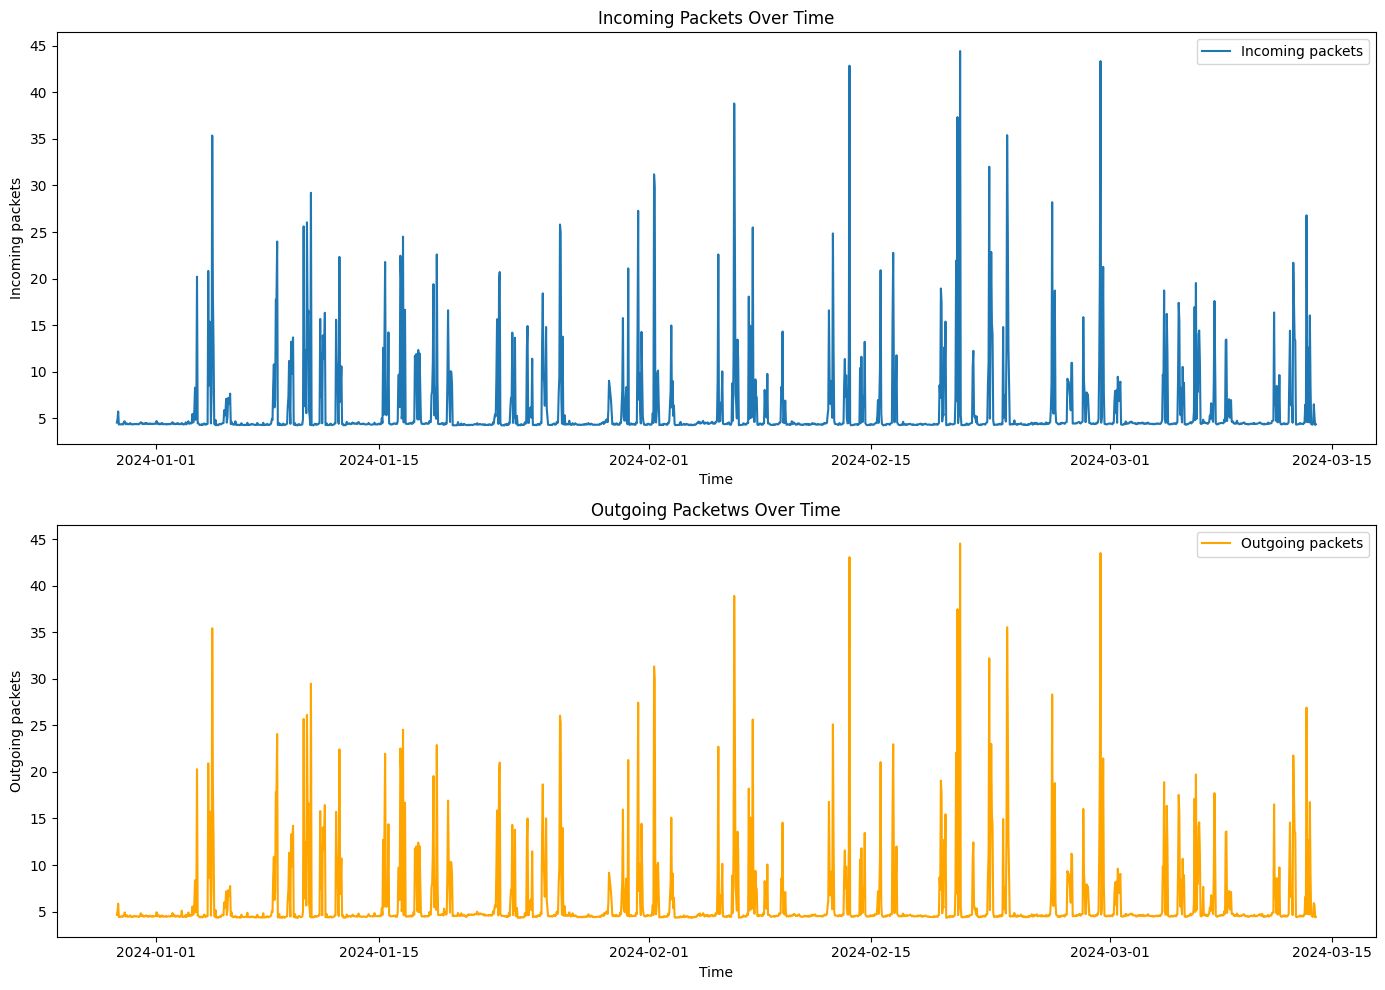

In [10]:
# EDA - Ploting Incoming and Outgoing Octets (ifHCInOctets and ifHCOutOctets) over time.
# Generate two plots for incoming and outgoing packets
fig, ax = plt.subplots(2, 1, figsize=(14, 10))
ax[0].plot(data_hourly['ifInUcastPackets'], label='Incoming packets')
ax[0].set_title('Incoming Packets Over Time')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Incoming packets')
ax[0].legend()

ax[1].plot(data_hourly['ifOutUcastPackets'], label='Outgoing packets', color='orange')
ax[1].set_title('Outgoing Packetws Over Time')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Outgoing packets')
ax[1].legend()

plt.tight_layout()
plt.show()


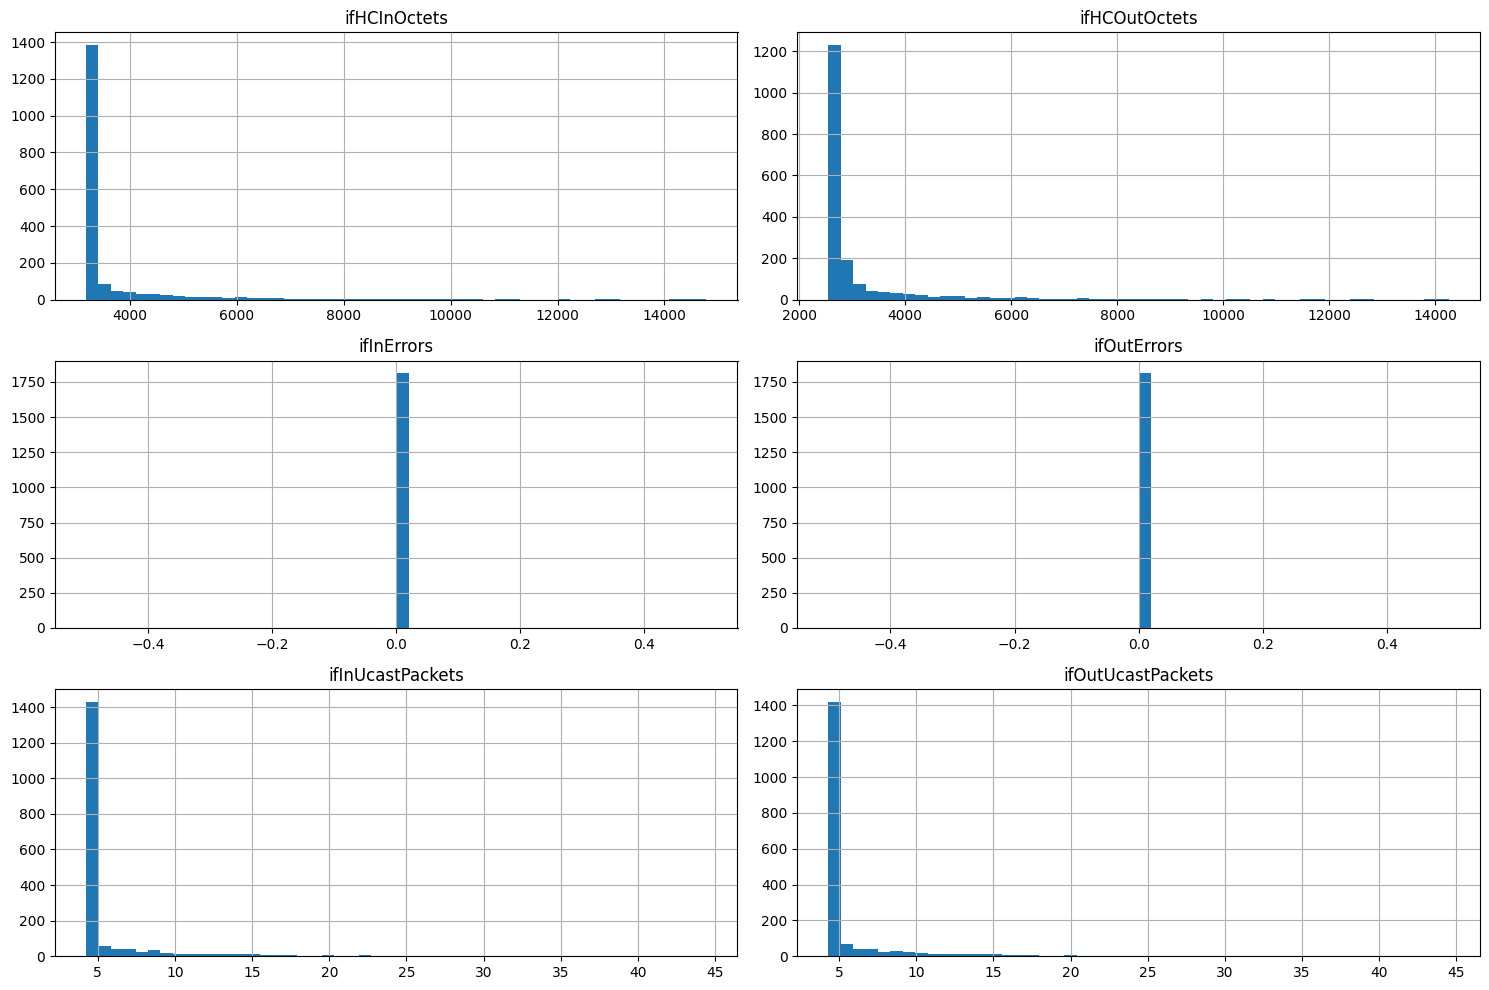

In [12]:
#Plotting histogram of all columns
data_hourly.hist(figsize=(15, 10), bins=50)
plt.tight_layout()
plt.show()

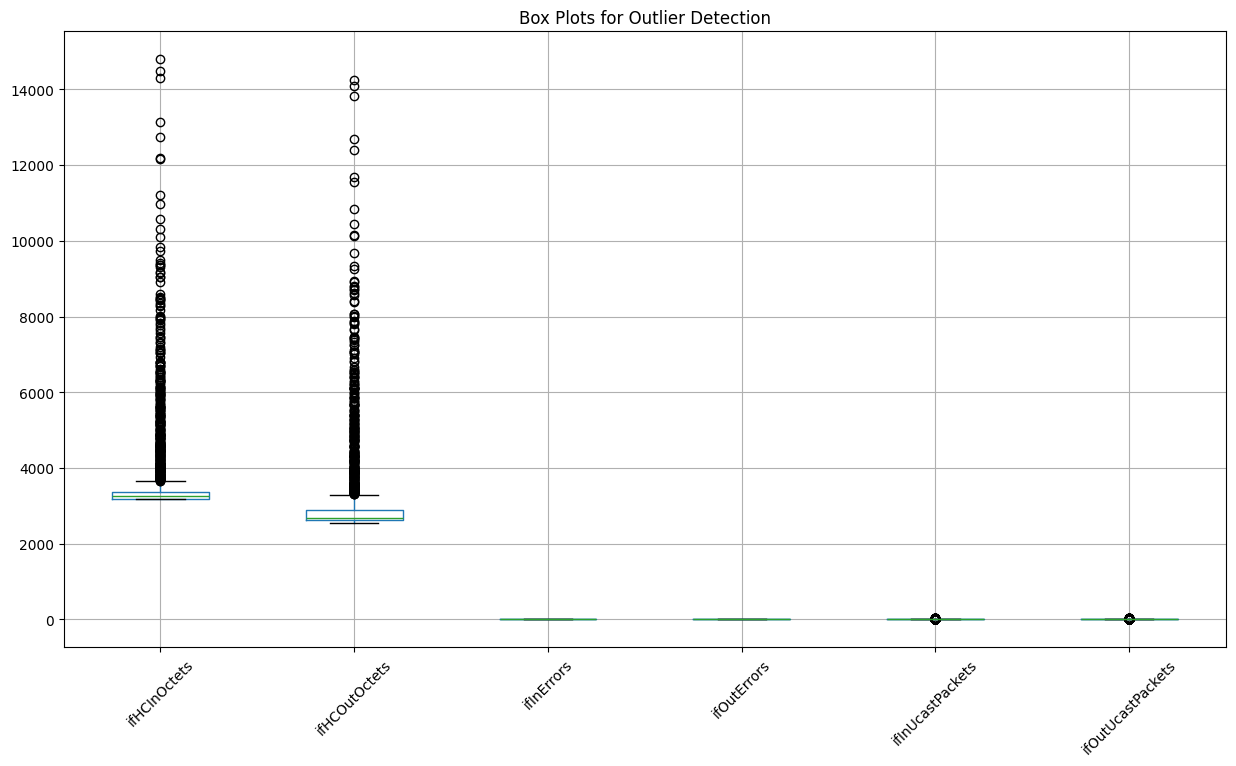

In [11]:
# Box plots for outlier detection
plt.figure(figsize=(15, 8))
data_hourly.boxplot()
plt.title('Box Plots for Outlier Detection')
plt.xticks(rotation=45)
plt.show()

<b>For the purpose of forecasting, we will be focusing on ifHCInOctets and ifHCOutOctets data coloumn for link utilisation.</b>

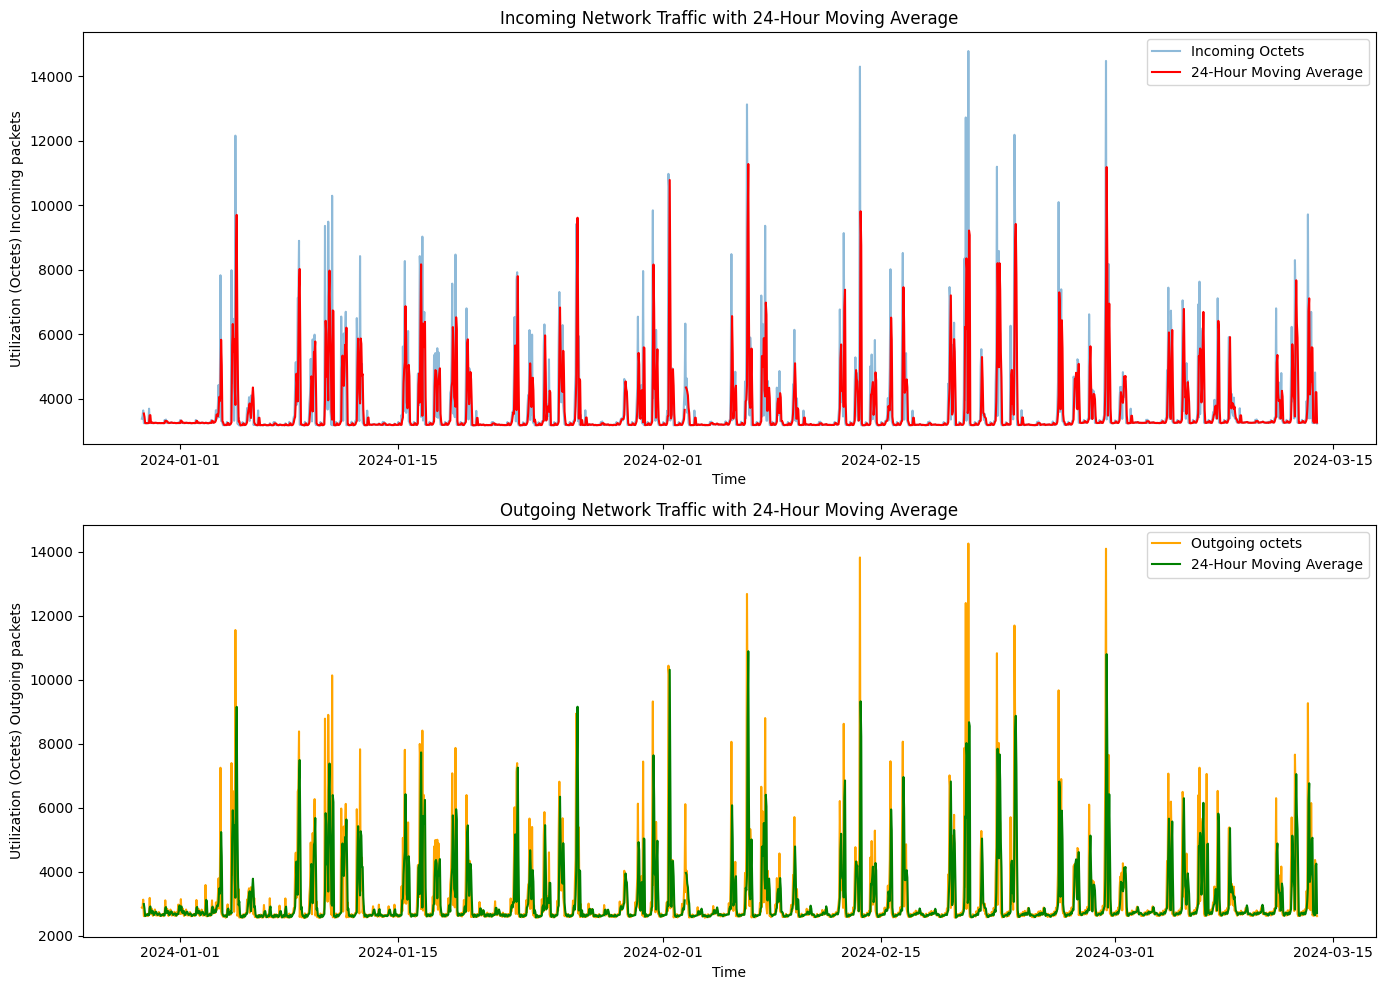

In [15]:
# Calculate 24-hour moving averages for utilization. To check if there is any trend in the data.
data_hourly['ifHCInOctets_MA'] = data['ifHCInOctets'].rolling(window=24).mean()
data_hourly['ifHCOutOctets_MA'] = data['ifHCOutOctets'].rolling(window=24).mean()

# # Plot the moving average along with the original data
# plt.figure(figsize=(14, 6))
# plt.plot(data_hourly['ifHCInOctets'], label='Incoming Octets', alpha=0.5)
# plt.plot(data_hourly['ifHCInOctets_MA'], label='24-Hour Moving Average', color='red')
# plt.title('Incoming Network Traffic with 24-Hour Moving Average')
# plt.xlabel('Time')
# plt.ylabel('Utilization (Octets)')
# plt.legend()
# plt.show()

fig, ax = plt.subplots(2, 1, figsize=(14, 10))
ax[0].plot(data_hourly['ifHCInOctets'], label='Incoming Octets', alpha=0.5)
ax[0].plot(data_hourly['ifHCInOctets_MA'], label='24-Hour Moving Average', color='red')
ax[0].set_title('Incoming Network Traffic with 24-Hour Moving Average')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Utilization (Octets) Incoming packets')
ax[0].legend()

ax[1].plot(data_hourly['ifHCOutOctets'], label='Outgoing octets', color='orange')
ax[1].plot(data_hourly['ifHCOutOctets_MA'], label='24-Hour Moving Average', color='green')
ax[1].set_title('Outgoing Network Traffic with 24-Hour Moving Average')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Utilization (Octets) Outgoing packets')
ax[1].legend()

plt.tight_layout()
plt.show()


<Figure size 1400x600 with 0 Axes>

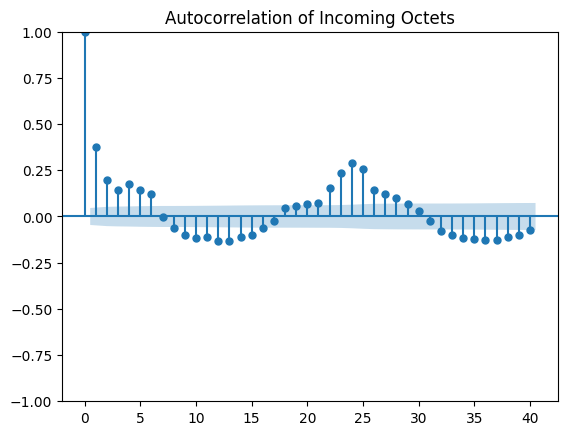

<Figure size 1400x600 with 0 Axes>

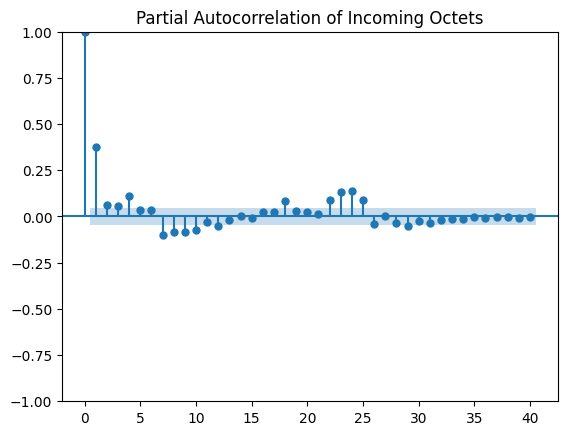

<Figure size 1400x600 with 0 Axes>

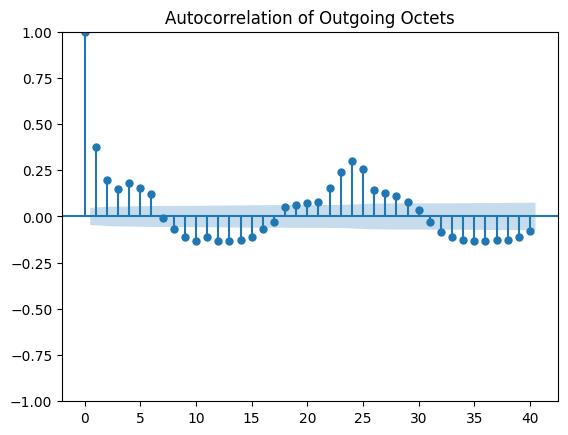

<Figure size 1400x600 with 0 Axes>

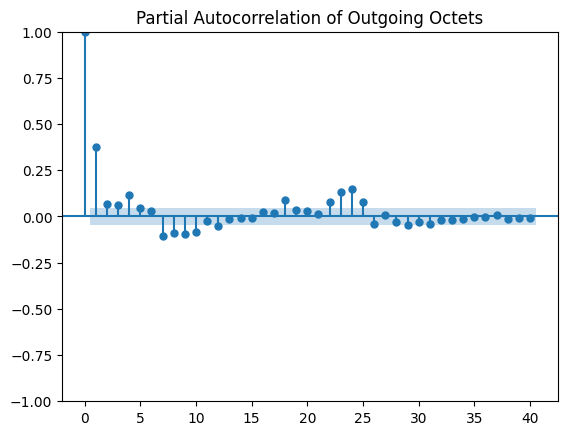

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for Outgoing Octets to determine the order of AR and MA terms, and to check for stationarity
plt.figure(figsize=(14, 6))
plot_acf(data_hourly['ifHCInOctets'], lags=40)
plt.title('Autocorrelation of Incoming Octets')
plt.show()

plt.figure(figsize=(14, 6))
plot_pacf(data_hourly['ifHCInOctets'], lags=40)
plt.title('Partial Autocorrelation of Incoming Octets')
plt.show()

plt.figure(figsize=(14, 6))
plot_acf(data_hourly['ifHCOutOctets'], lags=40)
plt.title('Autocorrelation of Outgoing Octets')
plt.show()

plt.figure(figsize=(14, 6))
plot_pacf(data_hourly['ifHCOutOctets'], lags=40)
plt.title('Partial Autocorrelation of Outgoing Octets')
plt.show()



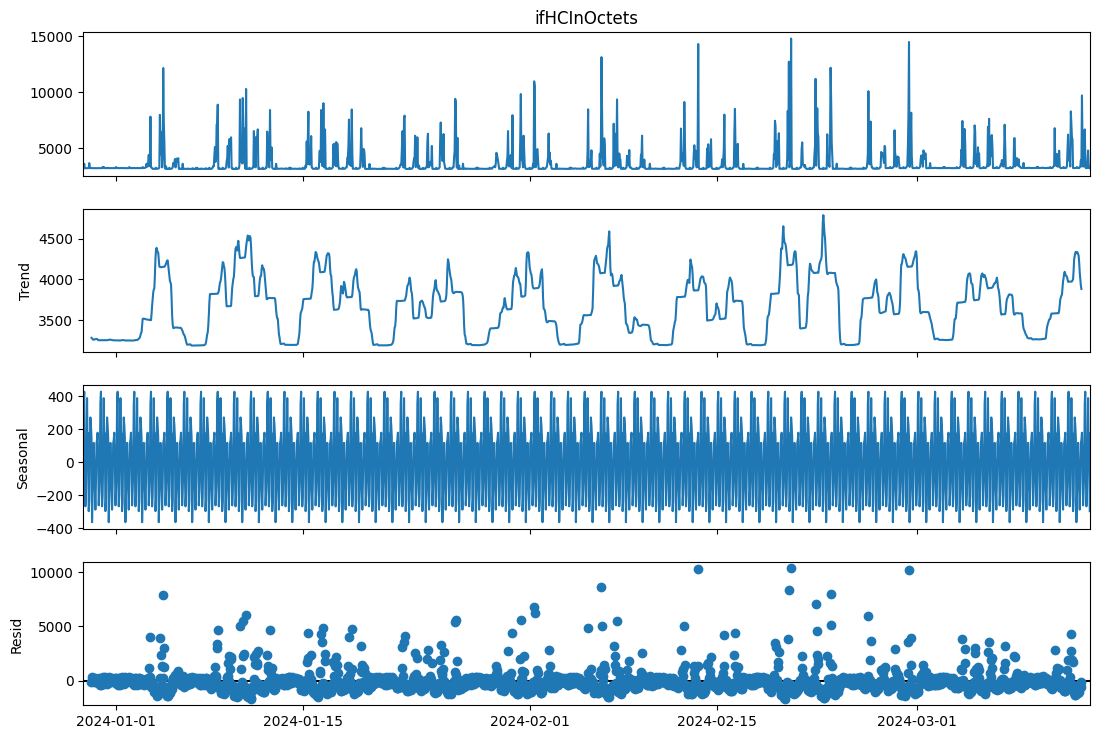

In [43]:
# Checking the seasonal decomposition of the data_hourly for incoming octets

decomposition = seasonal_decompose(data_hourly['ifHCInOctets'], model='additive', period=30)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

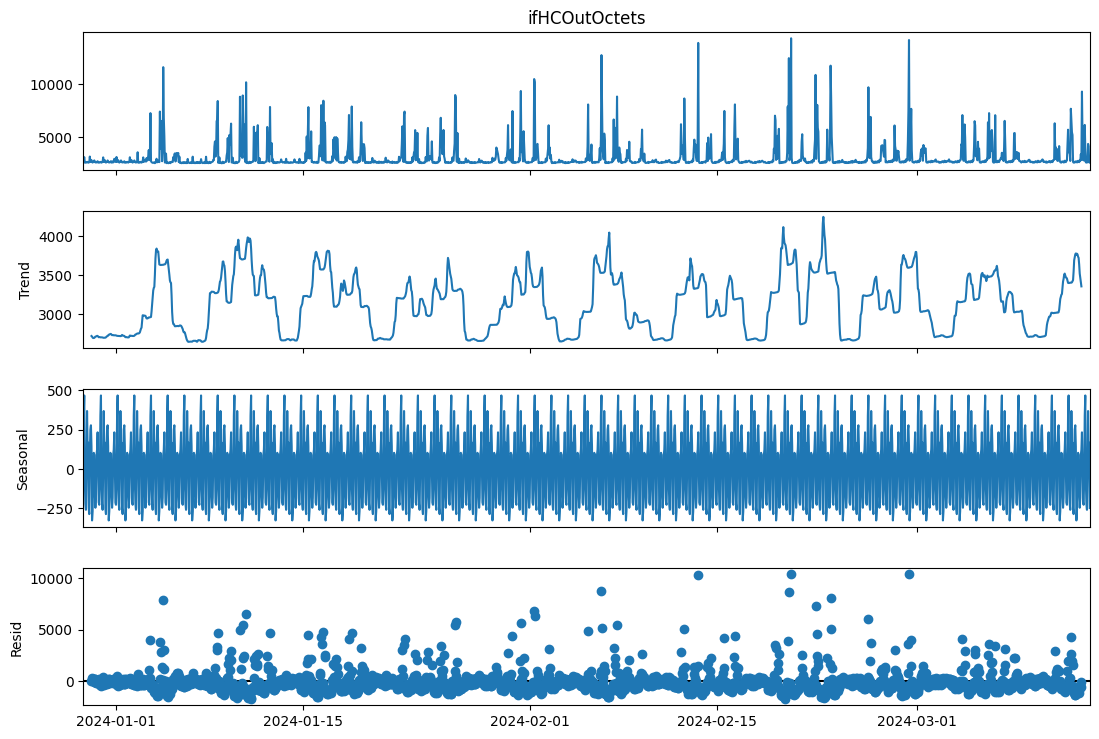

In [17]:
# Checking the seasonal decomposition of the data_hourly for outgoing octets

decomposition = seasonal_decompose(data_hourly['ifHCOutOctets'], model='additive', period=30)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

In [19]:
#stationarity check for incoming octets using the Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
test_results = adfuller(data_hourly['ifHCInOctets'])
print('ADF Statistic: %f' % test_results[0])    
print('p-value: %f' % test_results[1])
print('Critical Values:')
for key, value in test_results[4].items():
    print('\t%s: %.3f' % (key, value))
if test_results[1] < 0.05:
	print('Reject the null hypothesis: The time series is stationary.')
else:
	print('Failed to reject the null hypothesis: The time series is non-stationary. ')


ADF Statistic: -5.279286
p-value: 0.000006
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Reject the null hypothesis: The time series is stationary.


In [18]:
#stationarity check for outgoing octets using the Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
test_results = adfuller(data_hourly['ifHCOutOctets'])
print('ADF Statistic: %f' % test_results[0])    
print('p-value: %f' % test_results[1])
print('Critical Values:')
for key, value in test_results[4].items():
    print('\t%s: %.3f' % (key, value))
if test_results[1] < 0.05:
	print('Reject the null hypothesis: The time series is stationary.')
else:
	print('Failed to reject the null hypothesis: The time series is non-stationary. ')


ADF Statistic: -5.242646
p-value: 0.000007
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Reject the null hypothesis: The time series is stationary.


<b>Since the data is already stationary, we can directly fit models to perform forecasting

### Time Series Regression Forecast

Fitting a regression model based on hour, weekday and lag features and performing forecasting

C:\Users\Kaushik Srivatsan\AppData\Local\Temp\ipykernel_27116\1694219163.py:31: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



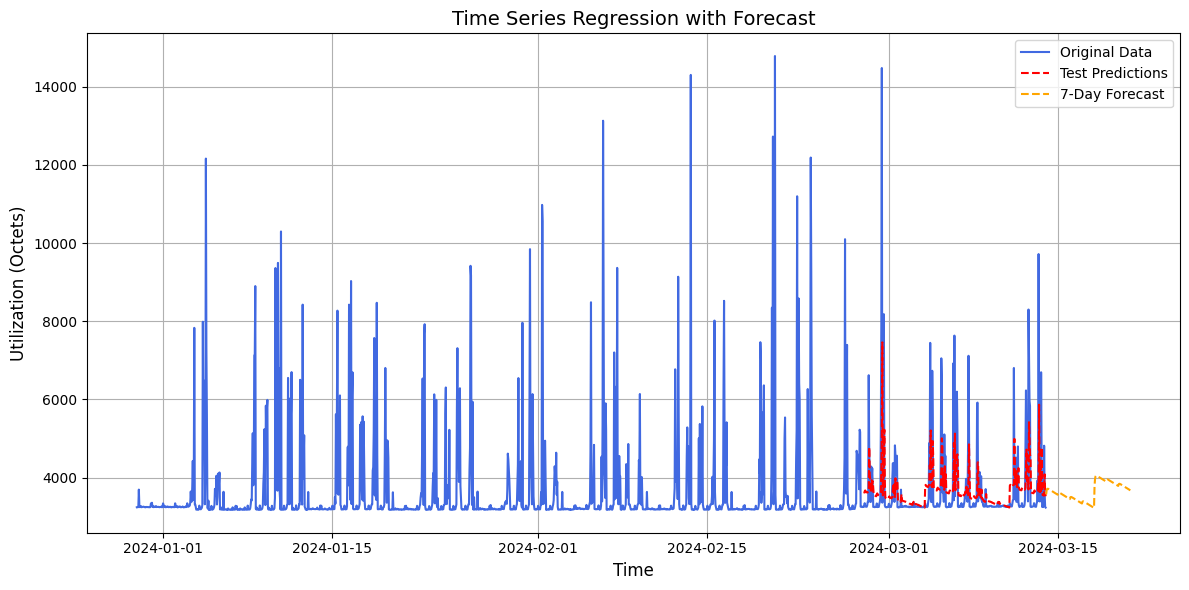

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# using hour and day of the week as features for the time series regression model.
data_hourly['hour'] = data_hourly.index.hour
data_hourly['day_of_week'] = data_hourly.index.dayofweek

# Lag features
data_hourly['lag_1'] = data_hourly['ifHCInOctets'].shift(1)
data_hourly.dropna(inplace=True)

# Train/test split
X = data_hourly[['hour', 'day_of_week', 'lag_1']]
y = data_hourly['ifHCInOctets']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fiting regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Extending the forecast: Forecast for the next 7 days (7 * 24 = 168 hours)
future_hours = 168

# Creating future time features for 7 days 168hrs
future_time = pd.date_range(start=data_hourly.index[-1], periods=future_hours + 1, freq='H')[1:]
future_df = pd.DataFrame({
    'hour': future_time.hour,
    'day_of_week': future_time.dayofweek
})

# Initialize the lag feature for future predictions with the last predicted value
future_df['lag_1'] = [X_test['lag_1'].iloc[-1]] + [None] * (future_hours - 1)

# Iteratively fill future lag_1 values based on model predictions
for i in range(1, future_hours):
    future_df.at[i, 'lag_1'] = model.predict(future_df.iloc[i - 1:i, :])[0]

# Forecast future values
future_y_pred = model.predict(future_df)

# Plot the original data, predictions, and forecast
plt.figure(figsize=(12, 6))
plt.plot(data_hourly.index, data_hourly['ifHCInOctets'], label='Original Data', color='royalblue')
plt.plot(X_test.index, y_pred, label='Test Predictions', color='red', linestyle='--')
plt.plot(future_time, future_y_pred, label='7-Day Forecast', color='orange', linestyle='--')

plt.title("Time Series Regression with Forecast", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Utilization (Incoming Octets)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Yellow indicates the 7-day forcast using time series regression for incoming octets.

C:\Users\Kaushik Srivatsan\AppData\Local\Temp\ipykernel_30464\2108532461.py:32: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_time = pd.date_range(start=data_hourly.index[-1], periods=future_hours + 1, freq='H')[1:]


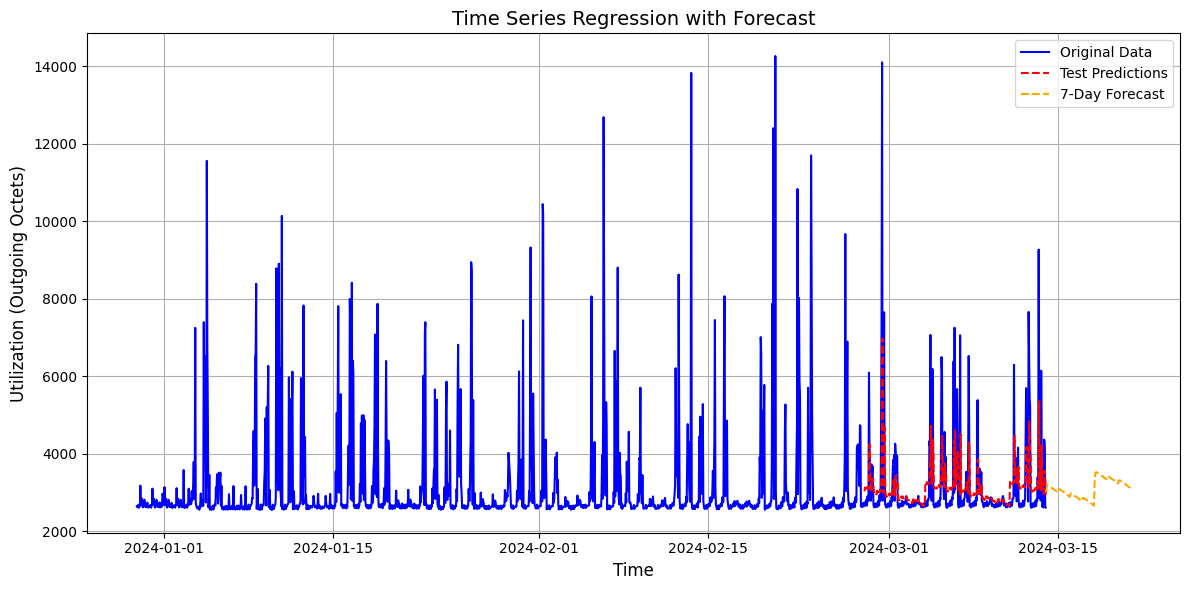

In [22]:
#Performing the same operations for outgoing octets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# using hour and day of the week as features for the time series regression model.
data_hourly['hour'] = data_hourly.index.hour
data_hourly['day_of_week'] = data_hourly.index.dayofweek

# Lag features
data_hourly['lag_1_out'] = data_hourly['ifHCOutOctets'].shift(1)
data_hourly.dropna(inplace=True)

# Train/test split
X = data_hourly[['hour', 'day_of_week', 'lag_1_out']]
y = data_hourly['ifHCOutOctets']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fiting regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Extending the forecast: Forecast for the next 7 days (7 * 24 = 168 hours)
future_hours = 168

# Creating future time features for 7 days 168hrs
future_time = pd.date_range(start=data_hourly.index[-1], periods=future_hours + 1, freq='H')[1:]
future_df = pd.DataFrame({
    'hour': future_time.hour,
    'day_of_week': future_time.dayofweek
})

# Initialize the lag feature for future predictions with the last predicted value
future_df['lag_1_out'] = [X_test['lag_1_out'].iloc[-1]] + [None] * (future_hours - 1)

# Iteratively fill future lag_1 values based on model predictions
for i in range(1, future_hours):
    future_df.at[i, 'lag_1_out'] = model.predict(future_df.iloc[i - 1:i, :])[0]

# Forecast future values
future_y_pred = model.predict(future_df)

# Plot the original data, predictions, and forecast
plt.figure(figsize=(12, 6))
plt.plot(data_hourly.index, data_hourly['ifHCOutOctets'], label='Original Data', color='blue')
plt.plot(X_test.index, y_pred, label='Test Predictions', color='red', linestyle='--')
plt.plot(future_time, future_y_pred, label='7-Day Forecast', color='orange', linestyle='--')

plt.title("Time Series Regression with Forecast", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Utilization (Outgoing Octets)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Yellow indicates the 7-day forcast using time series regression for incoming octets.

### ARIMA model and Forecasting

Figuring out the best ARIMA model that fits the data and , use that p,d,q values and fit the model, perform forecasting

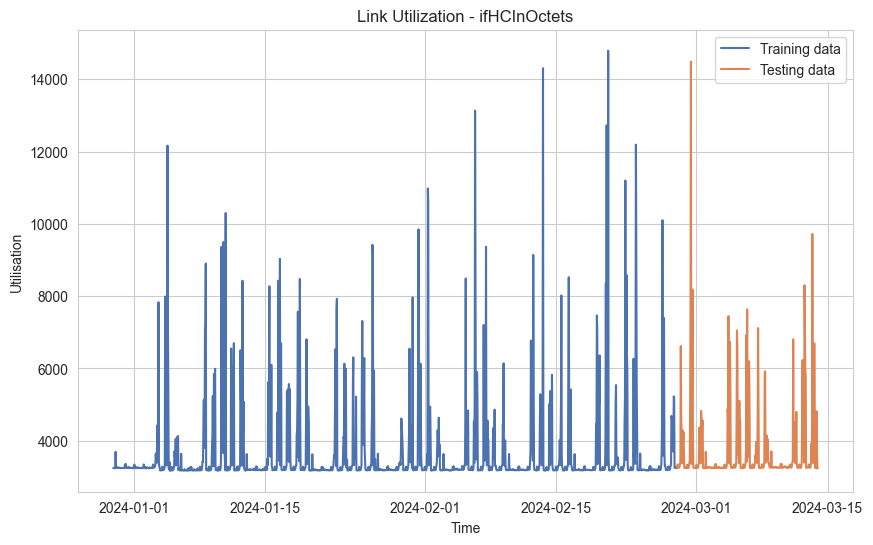

In [49]:
#splitting the data using train test split 80% train and 20% test
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_hourly['ifHCInOctets'], train_size=0.80, shuffle=False)
train_data2, test_data2 = train_test_split(data_hourly['ifHCOutOctets'], train_size=0.80, shuffle=False)


#plotting the train and test data
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Training data')
plt.plot(test_data, label='Testing data')
plt.title('Link Utilization - ifHCInOctets')
plt.xlabel('Time')
plt.ylabel('Utilisation')
plt.legend()
plt.show()



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=24669.270, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=24455.309, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=24494.735, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=27945.983, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=24451.432, Time=0.25 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=24446.197, Time=0.21 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=24432.906, Time=0.21 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=24433.489, Time=0.21 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=24434.817, Time=0.27 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=24447.892, Time=0.21 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=24435.464, Time=0.55 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=24600.486, Time=0.11 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0] intercept
Total fit time: 2.514 seconds
                               SARIMAX Results                              

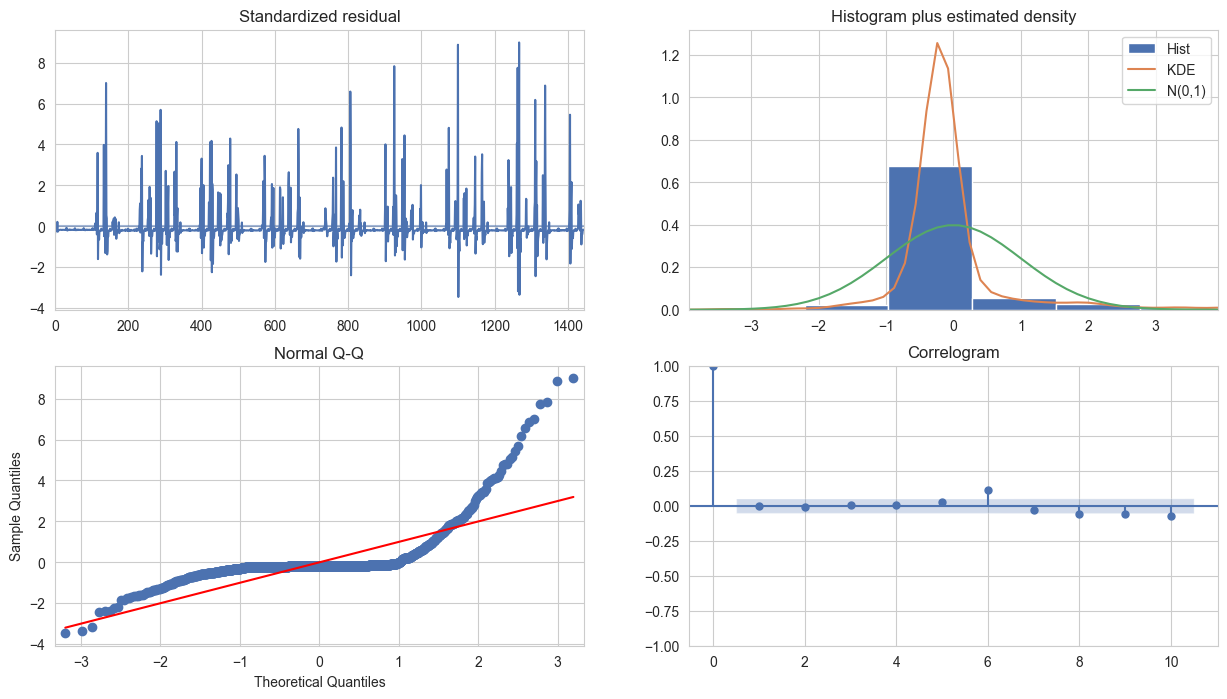

In [46]:
#applying autoarima model to the training data
from pmdarima.arima import auto_arima
smodel_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',      
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(smodel_autoARIMA.summary())
smodel_autoARIMA.plot_diagnostics(figsize=(15,8))
#print(f"Best ARIMA model: ARIMA{model.order}")
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=24706.967, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=24493.893, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=24534.413, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=27544.570, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=24489.052, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=24483.246, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=24467.061, Time=0.10 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=24467.303, Time=0.11 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=24468.930, Time=0.53 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=24484.852, Time=0.35 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=24469.280, Time=0.62 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=24626.563, Time=0.10 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0] intercept
Total fit time: 2.162 seconds
                               SARIMAX Results                              

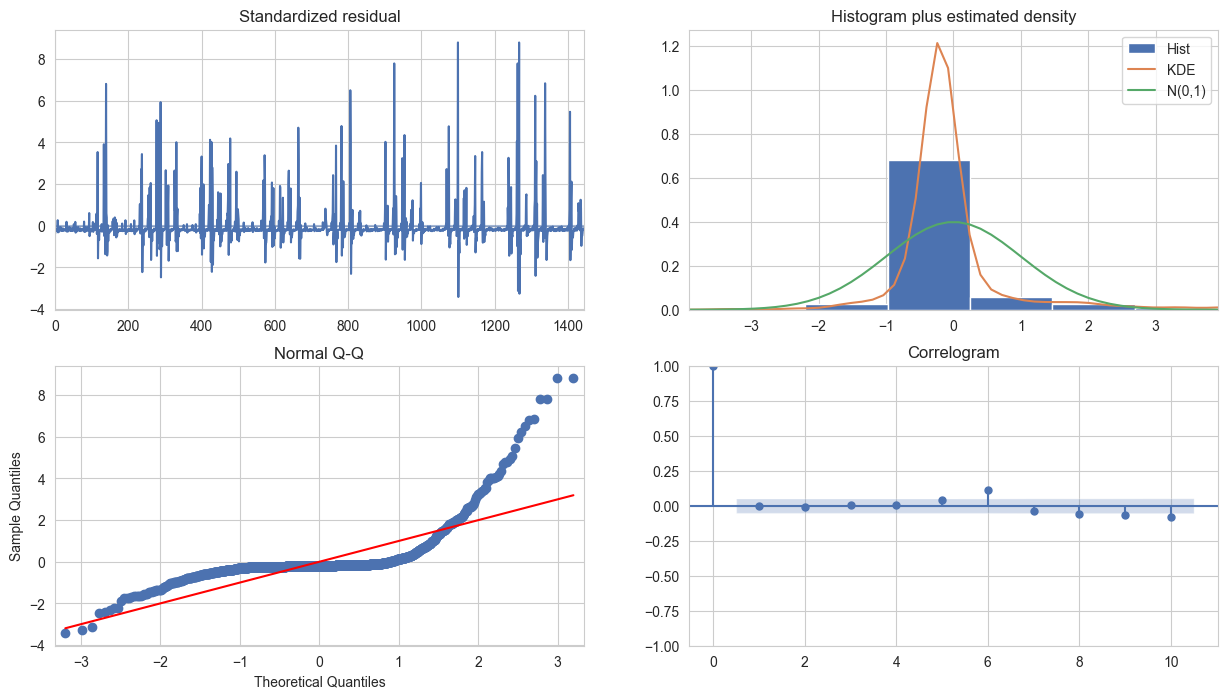

In [50]:
#applying autoarima model to the training data
from pmdarima.arima import auto_arima
smodel_autoARIMA = auto_arima(train_data2, start_p=0, start_q=0,
                      test='adf',       
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(smodel_autoARIMA.summary())
smodel_autoARIMA.plot_diagnostics(figsize=(15,8))
#print(f"Best ARIMA model: ARIMA{model.order}")
plt.show()

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\

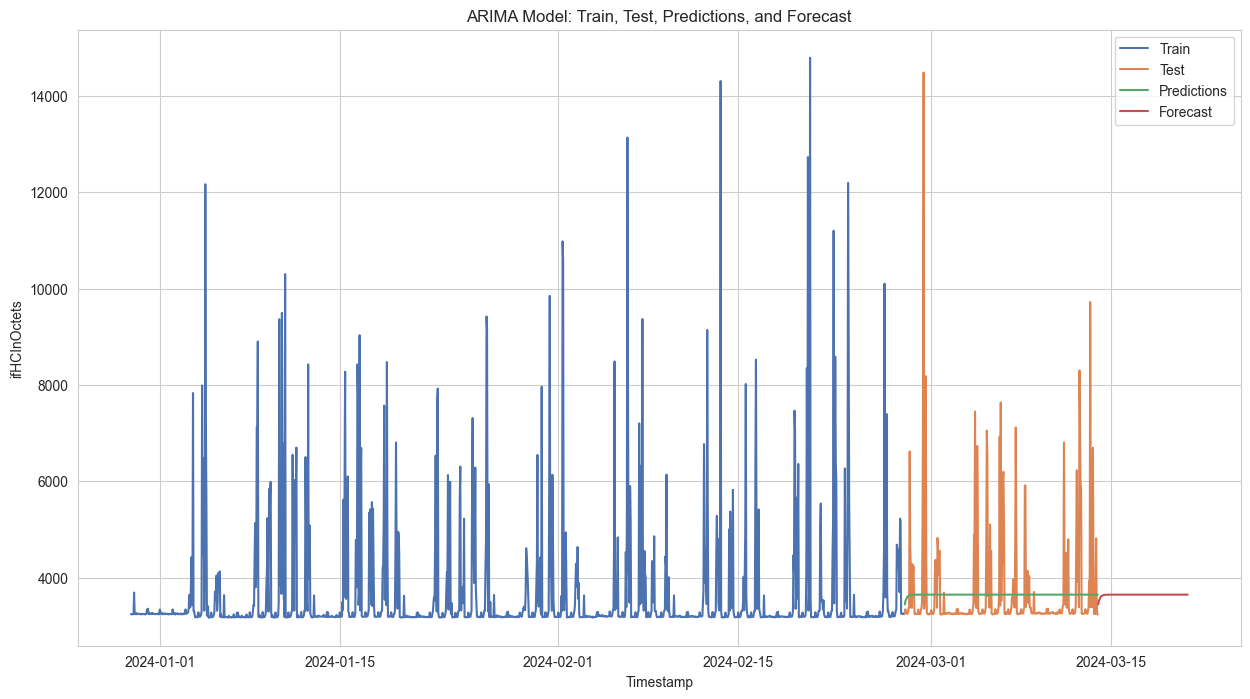


Forecast for the next 7 days:
1444    3447.312942
1445    3513.216513
1446    3543.236131
1447    3561.367228
1448    3590.740425
           ...     
1607    3649.937290
1608    3649.937290
1609    3649.937290
1610    3649.937290
1611    3649.937290
Name: predicted_mean, Length: 168, dtype: float64


In [47]:
from statsmodels.tsa.arima.model import ARIMA



arima_model = ARIMA(train_data, order=(4,0,0))
arima_results = arima_model.fit()

# Make predictions on the test set
predictions = arima_results.forecast(steps=len(test_data))


# Forecast for the next 7 days (assuming hourly data)
forecast = arima_results.forecast(steps=7*24)

# Plot the results
plt.figure(figsize=(15, 8))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(test_data.index, predictions, label='Predictions')
plt.plot(pd.date_range(start=test_data.index[-1], periods=len(forecast)+1, freq='H')[1:], forecast, label='Forecast')
plt.title('ARIMA Model: Train, Test, Predictions, and Forecast')
plt.xlabel('Timestamp')
plt.ylabel('ifHCInOctets')
plt.legend()
plt.show()

print("\nForecast Jncoming octets for the next 7 days:")
print(forecast)

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\

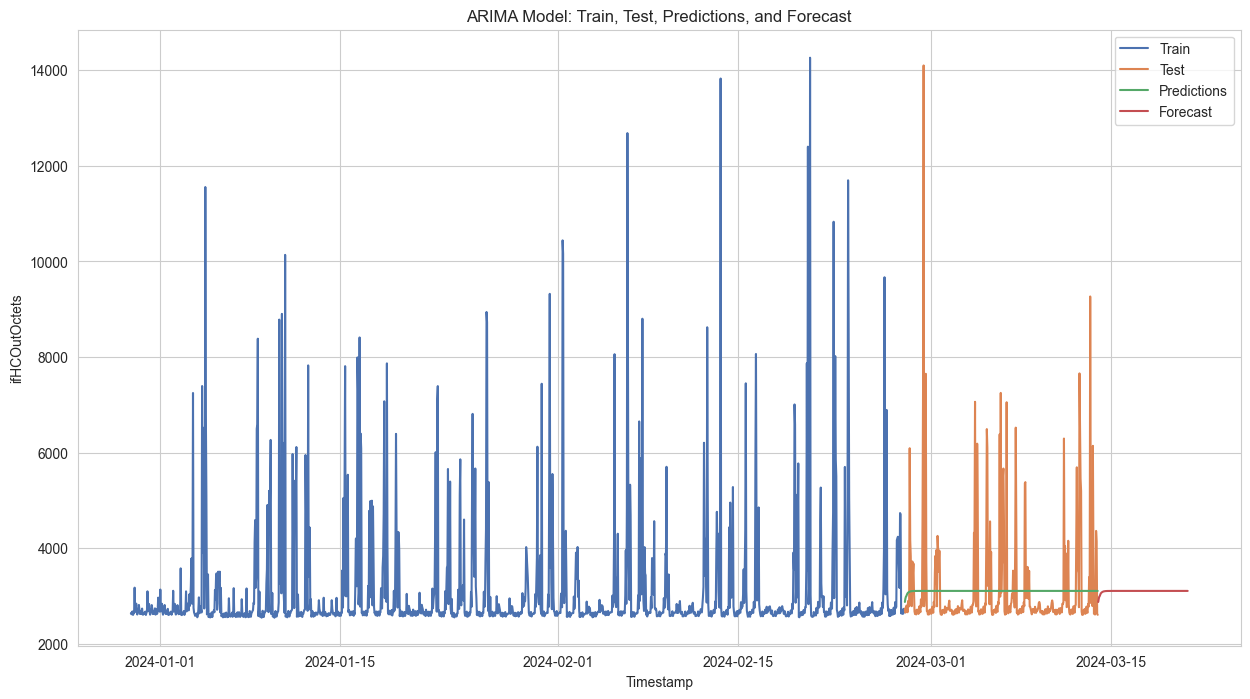


Forecast for the next 7 days:
1444    2879.671311
1445    2950.458034
1446    2990.972973
1447    3006.836115
1448    3040.008519
           ...     
1607    3110.631973
1608    3110.631973
1609    3110.631973
1610    3110.631973
1611    3110.631973
Name: predicted_mean, Length: 168, dtype: float64


In [51]:
from statsmodels.tsa.arima.model import ARIMA



arima_model = ARIMA(train_data2, order=(4,0,0))
arima_results = arima_model.fit()

# Make predictions on the test set
predictions = arima_results.forecast(steps=len(test_data2))


# Forecast for the next 7 days 
forecast = arima_results.forecast(steps=7*24)

# Plot the results
plt.figure(figsize=(15, 8))
plt.plot(train_data2.index, train_data2, label='Train')
plt.plot(test_data2.index, test_data2, label='Test')
plt.plot(test_data2.index, predictions, label='Predictions')
plt.plot(pd.date_range(start=test_data.index[-1], periods=len(forecast)+1, freq='H')[1:], forecast, label='Forecast')
plt.title('ARIMA Model: Train, Test, Predictions, and Forecast')
plt.xlabel('Timestamp')
plt.ylabel('ifHCOutOctets')
plt.legend()
plt.show()

print("\nForecast outgoing octets for the next 7 days:")
print(forecast)

Both Incoming and Outgoing Octets coloumns fit in the same Arima model and yield similar forecasting results ( seen in the diagrams)

### Exponential Smoothing method and Forecasting

Plotting Exponential Smoothing for Incoming Octets , and then making forecastsw based on that data. Followed by we iterate the same process for Outgoing octets of utilisation data


In [54]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Fit Exponential Smoothing Model
model_ets = ExponentialSmoothing(data_hourly['ifHCInOctets'], trend='add', seasonal='add', seasonal_periods=24).fit()

# Forecast for the next 7 days (168 hours)
forecast_ets = model_ets.forecast(steps=168)

# Plot
fig = make_subplots()
fig.add_trace(go.Scatter(
    x=data_hourly.index, 
    y=data_hourly['ifHCInOctets'], 
    mode='lines', 
    name='Original Data',
    line=dict(color='royalblue')
))

# Forecasted data
forecast_index = pd.date_range(start=data_hourly.index[-1], periods=168, freq='H')
fig.add_trace(go.Scatter(
    x=forecast_index, 
    y=forecast_ets, 
    mode='lines', 
    name='Forecast (Exponential Smoothing)',
    line=dict(color='orange', dash='dash')
))
fig.update_layout(
    title="Network Utilization Forecast (Incoming Octets) using Exponential Smoothing",
    xaxis_title="Time",
    yaxis_title="Utilization (Incoming Octets)",
   # template="plotly_dark",
    legend=dict(x=0.01, y=0.99)
)
fig.show()

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

C:\Users\Kaushik Srivatsan\AppData\Local\Temp\ipykernel_30464\1038485383.py:21: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



In [56]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Fit Exponential Smoothing Model
model_ets = ExponentialSmoothing(data_hourly['ifHCOutOctets'], trend='add', seasonal='add', seasonal_periods=24).fit()

# Forecast for the next 7 days (168 hours)
forecast_ets = model_ets.forecast(steps=168)

# Plot
fig = make_subplots()
fig.add_trace(go.Scatter(
    x=data_hourly.index, 
    y=data_hourly['ifHCOutOctets'], 
    mode='lines', 
    name='Original Data',
    line=dict(color='green')
))

# Forecasted data
forecast_index = pd.date_range(start=data_hourly.index[-1], periods=168, freq='H')
fig.add_trace(go.Scatter(
    x=forecast_index, 
    y=forecast_ets, 
    mode='lines', 
    name='Forecast (Exponential Smoothing)',
    line=dict(color='orange', dash='dash')
))
fig.update_layout(
    title="Network Utilization Forecast (Outgoing Octets) using Exponential Smoothing",
    xaxis_title="Time",
    yaxis_title="Utilization (Outgoing Octets)",
   # template="plotly_dark",
    legend=dict(x=0.01, y=0.99)
)
fig.show()

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

C:\Users\Kaushik Srivatsan\AppData\Local\Temp\ipykernel_30464\816715460.py:21: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



### Final Observations

In this assignment forecasting has been performed for link utilisation data in 3 different methods for both Incoming and Outgoing octets. While all three methods gave out varied predictions and different plots, all 3 can be considered in analysing and predicting future forecasts. One main parameter that has definetly affected the forecast results have been the conversion of timestamp to hourly units combining the data to hourly aggregates. In the end, while ARIMA forecasts a straight line, both the regression and smoothing shows some sort of increase and decrease seasonal cycle .
